## Imports and directory

In [1]:
!nvidia-smi

Wed Jan 29 12:45:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
"Restart Runtime"
import os
def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image, ImageDraw, ImageFont
from torchvision.models import vgg19_bn

import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloads and Path

In [0]:
#cp -r "drive/My Drive/camvid" ./
path = untar_data(URLs.CAMVID, dest="./")

In [5]:
path.ls()

[PosixPath('camvid/labels'),
 PosixPath('camvid/images'),
 PosixPath('camvid/codes.txt'),
 PosixPath('camvid/valid.txt'),
 PosixPath('camvid/images_pruned')]

In [5]:
!mkdir camvid/images_pruned
path_Y = path/'images'
path_X = path/'images_pruned'

mkdir: cannot create directory ‘camvid/images_pruned’: File exists


## Data

In [6]:
il = ImageList.from_folder(path_Y)
print(il)

ImageList (701 items)
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
Path: camvid/images


Testing Crappification on single image

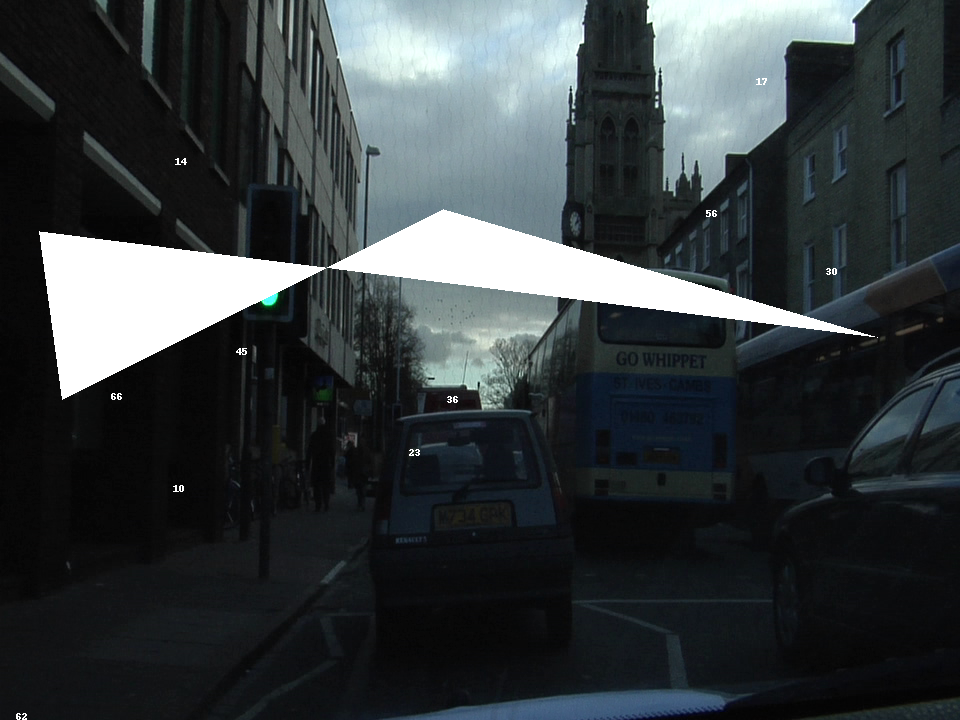

In [13]:
img = PIL.Image.open(f'{path_Y}/0001TP_006690.png')

width, height = img.size

_1a = random.randint(0, int(width/2));    _2a = random.randint(_1a, int(_1a*2))
_1b = random.randint(0, int(height/2));   _2b = random.randint(_1b, int(_1b*2))

_3a = random.randint(0, int(width/2));    _4a = random.randint(_3a, int(_3a*2))
_3b = random.randint(0, int(height/2));   _4b = random.randint(_1b, int(_1b*2))


ImageDraw.Draw(img).polygon(((_1a,_1b), (_2a,_2b), (_3a,_3b), (_4a,_4b)), fill=(255,255,255))

for text in range(10):
  q = random.randint(10,70)
  ImageDraw.Draw(img).text((random.randint(0,width),random.randint(0,height)), str(q), fill=(255,255,255))

img

Crappification Logic

In [0]:
def generate_pruned(fn, i):
    dest = path_X / fn.relative_to(path_Y)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)

    width, height = img.size

    _1a = random.randint(int(width/4), int(width/1.5));    _2a = random.randint(_1a, int(_1a*2))
    _1b = random.randint(int(width/4), int(height/1.5));   _2b = random.randint(_1b, int(_1b*2))

    _3a = random.randint(0, int(width/2));    _4a = random.randint(_3a, int(_3a*2))
    _3b = random.randint(0, int(height/2));   _4b = random.randint(_1b, int(_1b*2))


    ImageDraw.Draw(img).polygon(((_1a,_1b), (_2a,_2b), (_3a,_3b), (_4a,_4b)), fill=(255,255,255))

    for text in range(20):
        ImageDraw.Draw(img).text(
            (random.randint(0, width), random.randint(0, height)),
            str(random.randint(10, 70)),
            fill=(255, 255, 255),
        )

    img.save(dest)


In [8]:
print(il.items)

[PosixPath('camvid/images/0016E5_08190.png') PosixPath('camvid/images/0006R0_f03750.png')
 PosixPath('camvid/images/0006R0_f02490.png') PosixPath('camvid/images/0016E5_08137.png') ...
 PosixPath('camvid/images/0001TP_007800.png') PosixPath('camvid/images/0016E5_04650.png')
 PosixPath('camvid/images/0006R0_f00990.png') PosixPath('camvid/images/0006R0_f02190.png')]


In [9]:
parallel(generate_pruned, il.items)

## Datasets

In [0]:
#bs = 2 => 11GB
bs = 3
arch = models.resnet34

src = ImageImageList.from_folder(path_X).split_by_rand_pct(0.05, seed=42)

In [0]:
def get_data(bs):
    data = (src.label_from_func(lambda x: path_Y/x.name)
           .transform(get_transforms(max_zoom=2.), tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [0]:
data = get_data(bs)

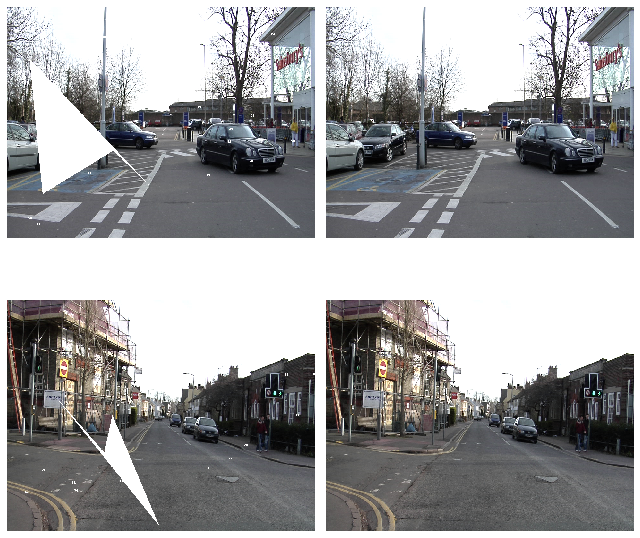

In [13]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Model

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [16]:
gram_matrix(t)

tensor([[[0.1330, 0.1345, 0.1367],
         [0.1345, 0.1363, 0.1386],
         [0.1367, 0.1386, 0.1412]],

        [[0.1330, 0.1345, 0.1367],
         [0.1345, 0.1363, 0.1386],
         [0.1367, 0.1386, 0.1412]]])

In [0]:
base_loss = F.l1_loss

In [0]:
vgg_m = vgg19_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [19]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 25, 38, 51],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss,
                     blur=True, norm_type=NormType.Spectral, 
                     callback_fns=ShowGraph, self_attention=True, 
                     y_range=(-3, 3)).to_fp16()
gc.collect();

In [0]:
!mkdir camvid/images_pruned/models
#!cp camvid/images_pruned/models/2_inpainting_perceptual_text.pth drive/My\ Drive/Object\ deletion/
!cp drive/My\ Drive/Object\ deletion/2_inpainting_perceptual_text.pth camvid/images_pruned/models/
learn.load('2_inpainting_perceptual_text')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


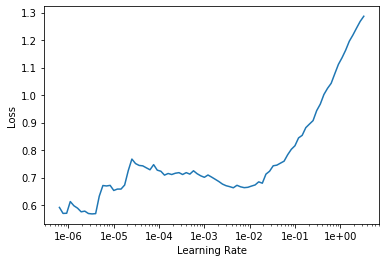

In [27]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-6

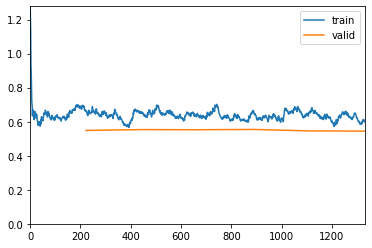

In [29]:
learn.fit_one_cycle(6, slice(lr), pct_start=0.9)

In [0]:
learn.save('1a')

In [0]:
#mkdir camvid/images_pruned/models
!cp camvid/images_pruned/models/1a.pth drive/My\ Drive/Object\ deletion/
#!cp drive/My\ Drive/Object\ deletion/1a.pth  camvid/images_pruned/models/

In [0]:
learn.load('1a')

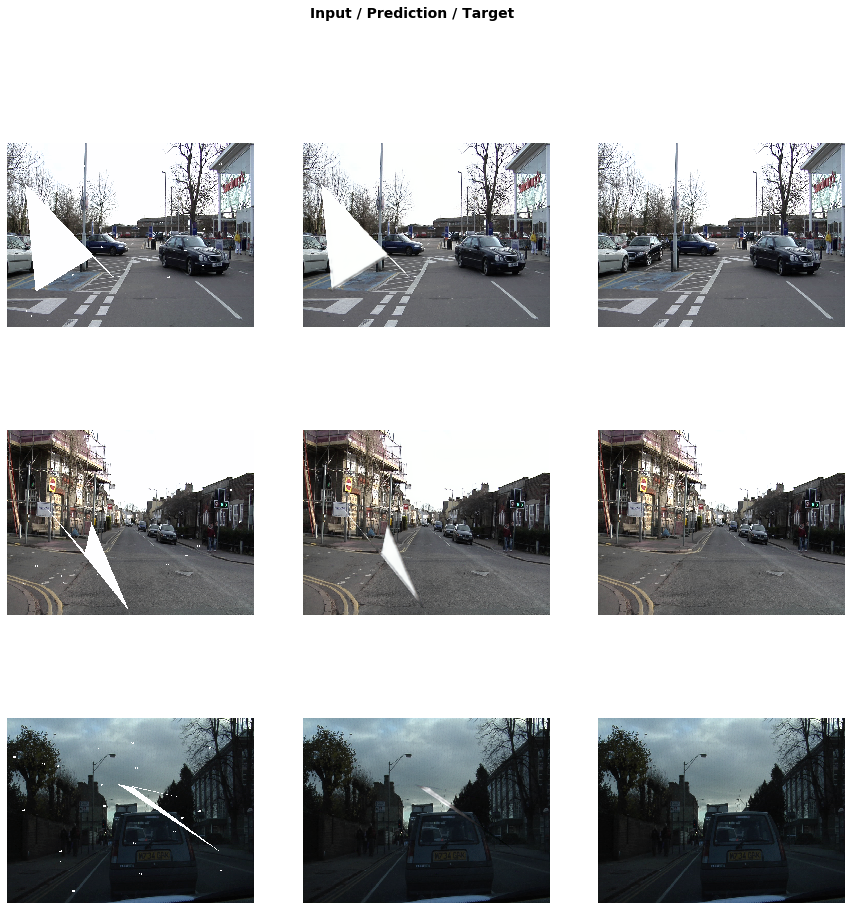

In [33]:
learn.show_results(rows=3, imgsize=5)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


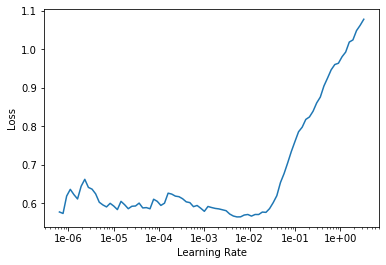

In [35]:
learn.lr_find()
learn.recorder.plot()

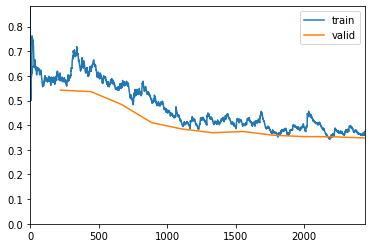

In [36]:
learn.fit_one_cycle(11, slice(1e-5, 5e-5), pct_start=0.9)

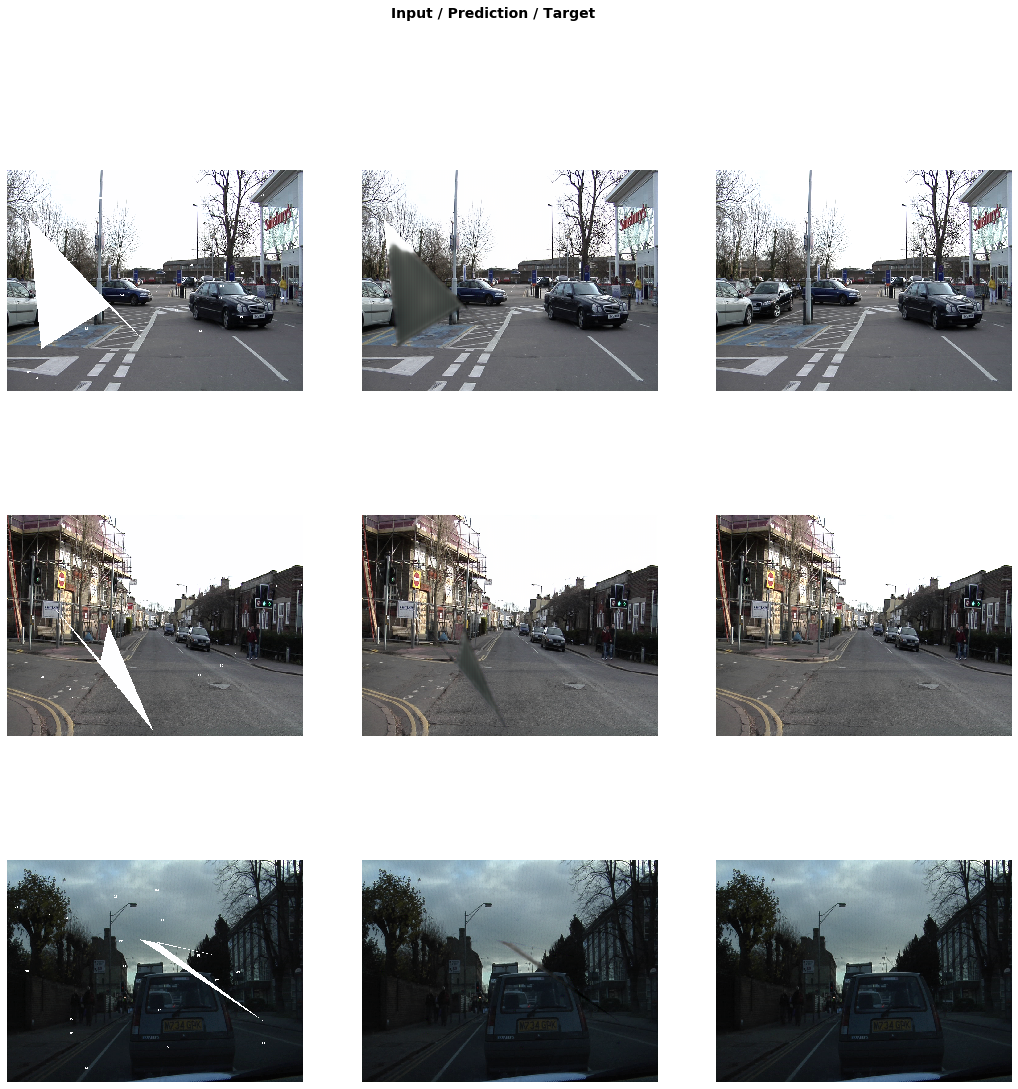

In [37]:
learn.show_results(rows=5, imgsize=6)

In [0]:
learn.save('2_inpainting_perceptual_shape')

In [0]:
#!mkdir camvid/images_pruned/models
!cp camvid/images_pruned/models/2_inpainting_perceptual_shape.pth drive/My\ Drive/Object\ deletion/
#!cp drive/My\ Drive/Object\ deletion/2_inpainting_perceptual_shape.pth camvid/images_pruned/models/

In [0]:
learn.load('2_inpainting_perceptual_shape')

## Export Learner

In [0]:
learn = learn.to_fp32()
learn.freeze()
learn.export('2_inpainting_perceptual_shape.pkl')

In [41]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 360, 480]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 360, 480]       128        True      
______________________________________________________________________
ReLU                 [64, 360, 480]       0          False     
______________________________________________________________________
MaxPool2d            [64, 180, 240]       0          False     
______________________________________________________________________
Conv2d               [64, 180, 240]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
__________________________________________________

In [0]:
#!cp camvid/images_pruned/models/2_inpainting_perceptual_shape.pth drive/My\ Drive/Object\ deletion/
!cp camvid/images_pruned/2_inpainting_perceptual_shape.pkl drive/My\ Drive/Object\ deletion/

In [43]:
ls drive/My\ Drive/Object\ deletion/

0006R0_f03420.png                   2_inpainting_perceptual_shape.pth
1a.pth                              2_Inpainting_Perceptual_Text.ipynb
1_Segmentation-fp16.ipynb           2_inpainting_perceptual_text.pkl
1_Segmentation.ipynb                2_inpainting_perceptual_text.pth
2a.pth                              camvid/
2_Inpainting_GAN.ipynb              critic-1a.pth
2_Inpainting_Perceptual.ipynb       gen-1a.pth
2_inpainting_perceptual.pkl         ReadMe.gdoc
2_inpainting_perceptual.pth         segmentation_crap.ipynb
2_inpainting_perceptual_shape2.pth  temp.pth
2_inpainting_perceptual_shape.pkl


## Inference time

In [0]:
"Restart Runtime"
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
  
  
path = '/content/drive/My Drive/Object deletion/'
learn = load_learner(path = path, file = '2_inpainting_perceptual_text.pkl')


img = open_image('/content/drive/My Drive/Object deletion/0006R0_f03420.png')
pred = learn.predict(img)

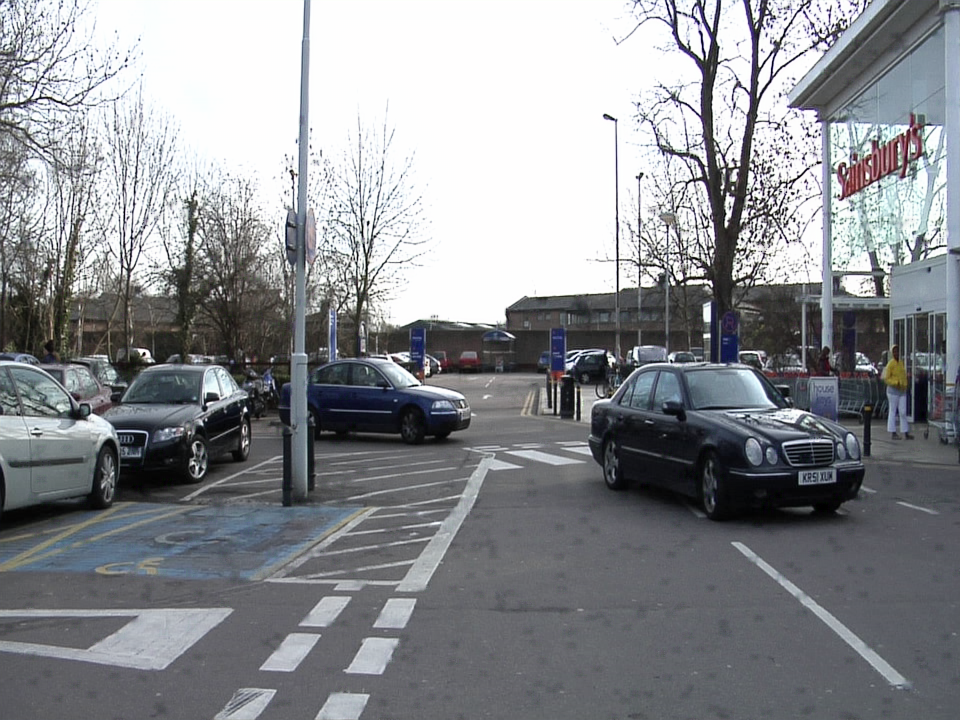

In [0]:
pred[0]